Model and Tokenizer

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
WORKING_DIR = '/kaggle/working'

In [3]:
modelf = VGG16()
# restructure the model
modelf = Model(inputs=modelf.inputs, outputs=modelf.layers[-2].output)
# summarize
print(modelf.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [22]:
with open('/kaggle/input/features2/features (4).pkl', 'rb') as f:
    features = pickle.load(f)

In [36]:
df=pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|')

In [37]:
df[' comment'] = df[' comment'].astype(str)

In [38]:
mapping={}
for i in range(len(df)):
    image_id=df["image_name"][i].split('.')[0]
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(df[" comment"][i])

In [39]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
#             caption=caption.astype(str)
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [40]:
clean(mapping)

In [11]:
mapping

{'1000092795': ['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
  'startseq two young white males are outside near many bushes endseq',
  'startseq two men in green shirts are standing in yard endseq',
  'startseq man in blue shirt standing in garden endseq',
  'startseq two friends enjoy time spent together endseq'],
 '10002456': ['startseq several men in hard hats are operating giant pulley system endseq',
  'startseq workers look down from up above on piece of equipment endseq',
  'startseq two men working on machine wearing hard hats endseq',
  'startseq four men on top of tall structure endseq',
  'startseq three men on large rig endseq'],
 '1000268201': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq little girl in pink dress going into wooden cabin endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl climbing into wooden playhous

In [41]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [42]:
len(all_captions)

158915

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [44]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [45]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [59]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

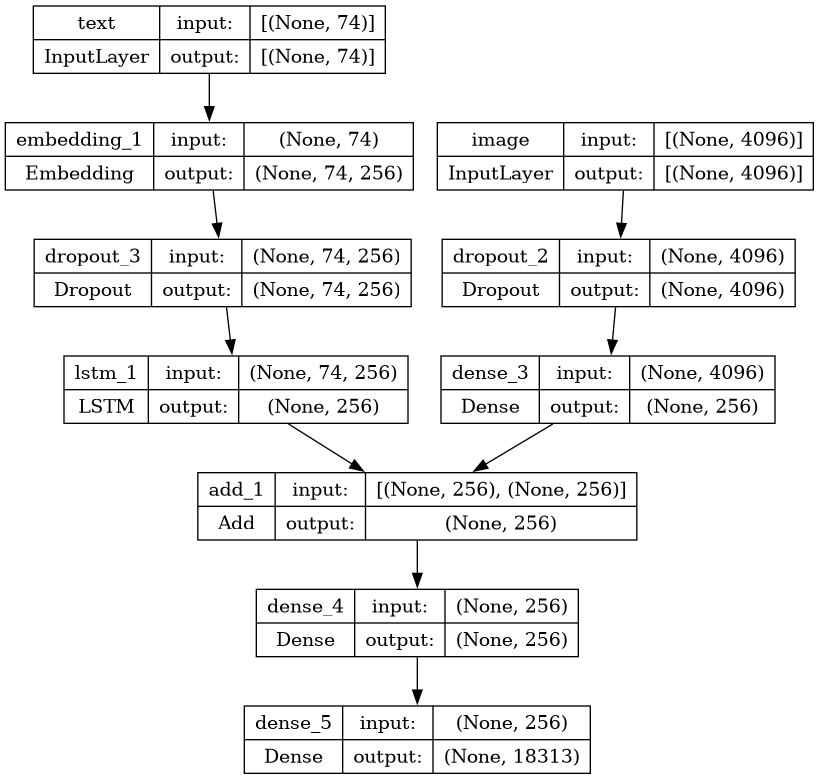

In [60]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [61]:
epochs = 4
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

893/893 [==============================] - 300s 336ms/step - loss: 3.3796


In [62]:
model.save('best_model7.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
import pickle

# Assuming 'tokenizer' is your tokenizer object
with open('tokenizer7.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)